<style>
.red-text {
    color: red;
}
</style>

# concrete-biopython quickstart

***concrete-biopython*** is a FHE library based on python ***biopython*** library. It implements the same objects and functions when they are compatible with fhe.


### FheSeq and FheMutableSeq classes

<span style="color:purple">***FheSeq***</span>  and <span style="color:purple">***FheMutableSeq***</span>  objects are the FHE implementations of biopython <span style="color:darkblue">***Seq***</span>  and <span style="color:darkblue">***MutableSeq***</span>  objects.

***Biopython*** <span style="color:darkblue">***Seq***</span> and <span style="color:darkblue">***MutableSeq***</span>  objects are constructed from a string, generally representing a **DNA**, **RNA** or a **protein** sequence. They provide functions to process this string sequence. <span style="color:darkblue">***MutableSeq***</span>  allows to modify this string while <span style="color:darkblue">***Seq***</span> does not.

<span style="color:purple">***FheSeq***</span>  and <span style="color:purple">***FheMutableSeq***</span>  implement the same functions (when they are compatible with FHE) with an encrypted array of integers encoding for the string sequence.

### Working with FheSeq and FheMutableSeq objects

Firs of all, we need to import ***numpy*** and ***concrete.fhe***, as well as <span style="color:darkblue">***Seq***</span>  and <span style="color:darkblue">***MutableSeq***</span>  from ***Bio.Seq***.
Then we import <span style="color:purple">***FheSeq***</span>  and <span style="color:purple">***FheMutableSeq***</span>  from ***concrete.biopython.FheSeq***, and also ***SeqWrapper.***<span style="color:darkred">***SeqWrapper***</span> which will allow to interface <span style="color:darkblue">***Seq***</span>  and <span style="color:darkblue">***MutableSeq***</span>  objects with <span style="color:purple">***FheSeq***</span>  and <span style="color:purple">***FheMutableSeq***</span>  objects.

In [2]:
import numpy as np
from concrete import fhe
from Bio.Seq import Seq, MutableSeq

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from concrete_biopython.FheSeq import FheSeq, FheMutableSeq
from concrete_biopython.SeqWrapper import SeqWrapper

Let's define a function ***process_seq*** that takes in input a <span style="color:darkblue">***Seq***</span>  and a <span style="color:darkblue">***MutableSeq***</span>  objects ***seq1*** and ***seq2***, and processes them using some of the possibilities offered by the library:

In [3]:
def process_seq(seq1, seq2):
    seq2.pop()
    new_seq = seq1.reverse_complement() + seq2[0:3]
    protein = new_seq.translate()
    return protein

Let's create two sequences and test this function:

In [4]:
seq1 = Seq('ACCAGGTAC')
seq2 = MutableSeq('CGTTAGC')
output_seq = process_seq(seq1, seq2)
print(output_seq)

VPGR


Now, we will see how we can run the function ***process_seq*** homomorphically, using <span style="color:purple">***FheSeq***</span>  and a <span style="color:purple">***FheMutableSeq***</span>  objects. 

We will need to follow the steps below:
1. convert <span style="color:darkblue">***Seq***</span>  and a <span style="color:darkblue">***MutableSeq***</span>  objects to integer arrays with <span style="color:darkred">***SeqWrapper***</span>***.toIntegers***
2. encrypt the integer arrays
3. create <span style="color:purple">***FheSeq***</span>  and a <span style="color:purple">***FheMutableSeq***</span>  objects from the encrypted integer arrays inside the circuit
4. call our function ***process_seq*** homomorphically on the FHE sequence objects
5. Convert back the output from a <span style="color:purple">***FheSeq***</span>  to an encrypted array with <span style="color:purple">***FheSeq***</span>***.toArray***
6. Decrypt the encrypted output array
7. convert the array back to a <span style="color:darkblue">***Seq***</span> object using <span style="color:darkred">***SeqWrapper***</span>***.toSeq***

<div>
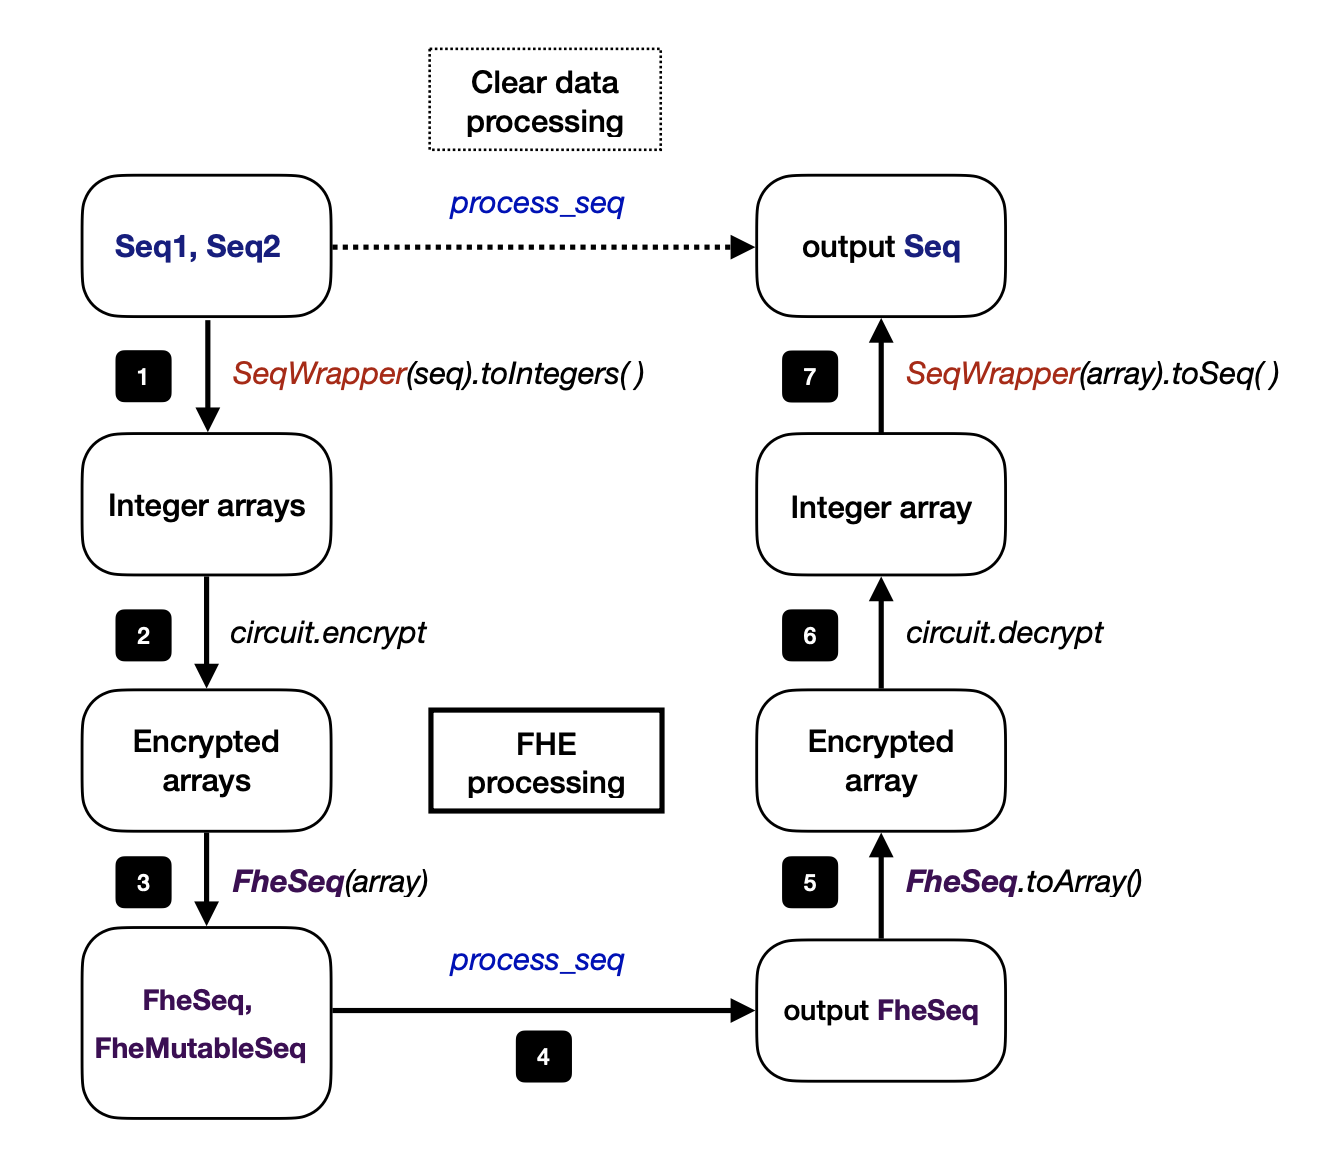
</div>

For steps 1., 2., 6. and 7., we can create a circuit wrapper to do the Seq to integer and integer to Seq conversions:

In [14]:
# wrap a circuit in order to input and output Bio.Seq objects
def circuit_wrapper(circuit, seq1, seq2, simulate=False):
    # convert Seq objects to integers with SeqWrapper.toIntegers
    integers1 = SeqWrapper(seq1).toIntegers()
    integers2 = SeqWrapper(seq2).toIntegers()
    
    # run the circuit with integer inputs
    integer_output = circuit.simulate(integers1, integers2) if simulate else circuit.encrypt_run_decrypt(integers1, integers2)

    # convert back the integer outputs into a Seq objects with SeqWrapper.toSeq
    return SeqWrapper(integer_output).toSeq()

For steps 3. and 5., we can create an adapter function that will be the circuit's main function. This function will create <span style="color:purple">***FheSeq***</span>  and <span style="color:purple">***FheMutableSeq***</span>  objects for the function ***process_seq*** to process on homomorphically, and then it will convert back the <span style="color:purple">***FheSeq***</span>  output into an encrypted integer array that the circuit can decrypt.

In [15]:
def process_seq_adapter(integer_seq1, integer_seq2):
    
    # convert integer sequences into FheSeq and FheMutableSeq objects
    seq1=FheSeq(integer_seq1)
    seq2=FheMutableSeq(integer_seq2)
    
    # process the sequence objects with our function
    new_seq = process_seq(seq1, seq2)
    
    # return the new sequence as integer array
    return new_seq.toArray()

For step 4., let's make the circuit from ***process_seq_adapter*** function, and create a correct inputset taking into account the number of possible letters with ***SeqWrapper.maxInteger()*** and the size of input sequences with ***len(seq1)*** and ***len(seq2)***:

In [16]:
# compile the process_seq_adapter function and create a circuit
compiler = fhe.Compiler(lambda data1,data2: process_seq_adapter(data1, data2), {"data1": "encrypted", "data2": "encrypted"})
circuit = compiler.compile(
    inputset=[
    (np.random.randint(0, SeqWrapper.maxInteger()+1, size=(len(seq1),)),
    np.random.randint(0, SeqWrapper.maxInteger()+1, size=(len(seq2),)))
    for _ in range(100)
    ],
    configuration=fhe.Configuration(
        enable_unsafe_features=True,
        use_insecure_key_cache=True,
        insecure_key_cache_location=".keys",
        dataflow_parallelize=False, # setting it to True makes the jupyter kernel crash
    ),
    verbose=False,
)

We can now run our wrapped circuit on the variables ***seq1*** and ***seq2*** defined earlier and compare the output sequence with the one obtained earlier:

In [18]:
# now we can run our circuit on Seq objects and compare the result with output_seq

# with simulation
fheSim_output_seq = circuit_wrapper(circuit, seq1, seq2, True)
print('Simulated :', fheSim_output_seq)
assert(output_seq == fheSim_output_seq)

# and without (slower)
fhe_output_seq = circuit_wrapper(circuit, seq1, seq2, False)
print('FHE :', fhe_output_seq)
assert(output_seq == fhe_output_seq)

Simulated : VPGR
FHE : VPGR
